In [67]:
%matplotlib inline
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from astropy.io import fits
from scipy import interpolate
import multiprocessing
import statsmodels.api as sm
from scipy.special import eval_legendre, eval_chebys
from numpy.linalg import inv
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy import interpolate
from scipy import optimize
import math
from numpy.polynomial.legendre import legval
import fnmatch

In [17]:
N_eff_blue = 520*160 #lines/mm * fiber size on camera
N_eff_red = 400*160 #lines/mm * fiber size on camera
slit_sep_blue = 1/520.
slit_sep_red = 1/400.

In [3]:
N_eff_red

64000

In [99]:
blue_w = 496 #mm
red_w = 740 #mm at zero deviation angle

In [37]:
def Yfit(N_eff, wave_range, wave_0, wave_blaze, f):
    a = np.pi * wave_range/wave_0
    b = np.pi * ((wave_range - wave_blaze)/wave_0) * f
    first = np.sinc(b)**2
    second = 0.5*(1/(N_eff*np.sin(a))**2.)
    return first*second

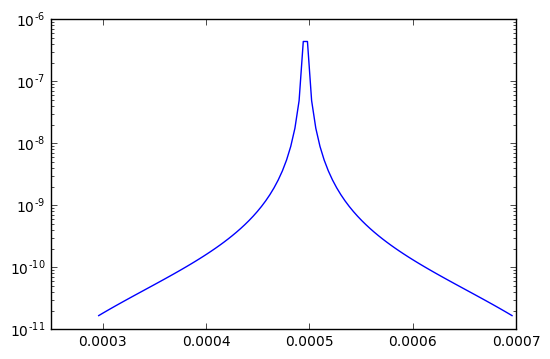

In [85]:
wave_range = np.linspace(blue_w-.0002, blue_w+.0002,100)
plt.semilogy(wave_range, Yfit(N_eff_blue, wave_range, blue_w, blue_w, .5))

In [95]:
#Airy Disk
from scipy import special
def airy_disk(wave, wave_0, theta, a):
    z = 2*np.pi * a * np.sin(np.deg2rad(theta))/ (wave_0-wave_range)
    top = 2* special.jv(1, z) 
    return (top/z)**2.

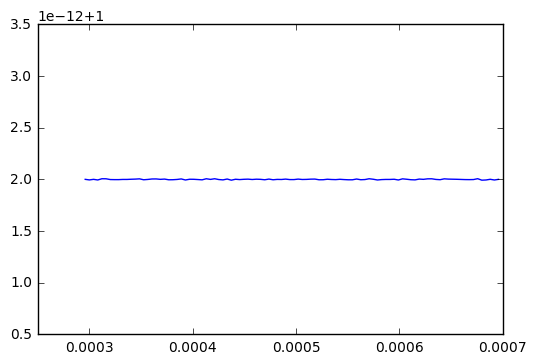

In [99]:

plt.plot(wave_range, airy_disk(wave_range, blue_w, 180, slit_sep_blue))

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


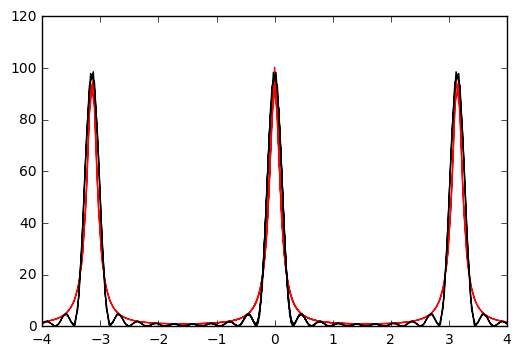

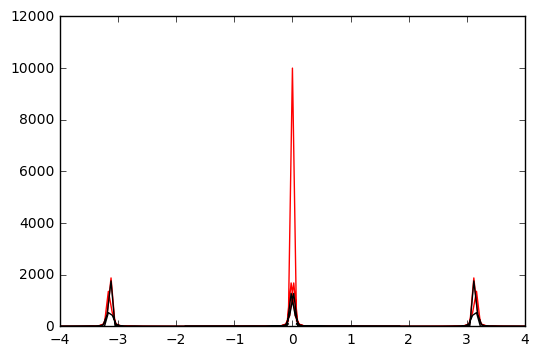

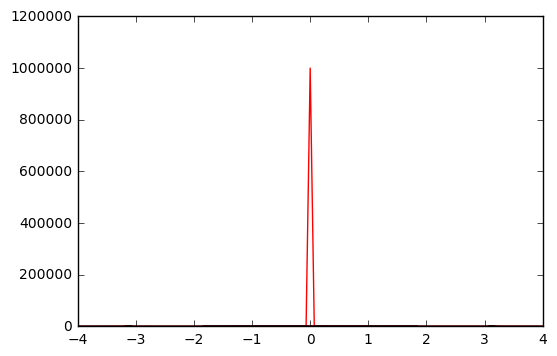

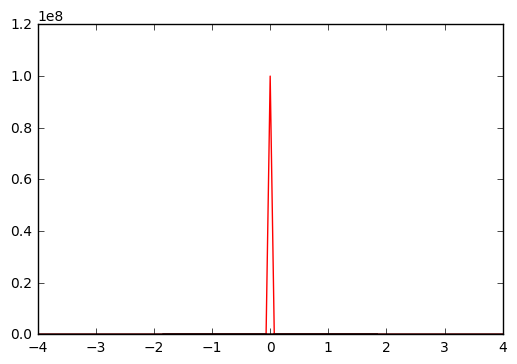

In [65]:
theta = np.linspace(-190,190, 1001)
#print(psi)
for N_eff in (10,100, 1000, 10000):
    plt.figure()
    plt.plot(E2(N_eff, red_w, slit_sep_red, theta)[0], E2(N_eff, red_w, slit_sep_red, theta)[1], 'r-')
    plt.plot(I2(N_eff, red_w, slit_sep_red, theta)[0], I2(N_eff, red_w, slit_sep_red, theta)[1], 'k-')
    plt.xlim(-4, 4)

In [58]:
#Get Arc files
ARC_DIR = '/Users/parkerf/Desktop/test_data/arcs/'
all_arc_files = glob.glob(ARC_DIR+"/**/*.fits.gz",recursive=True)

In [62]:
blue_arc_files = fnmatch.filter(all_arc_files,"*-b*-*")
red_arc_files = fnmatch.filter(all_arc_files,"*-r*-*")

In [63]:
def eval_tset(fiber_num, tset):
    nx = tset.XMAX - tset.XMIN + 1
    xmid = .5*(tset.XMIN+tset.XMAX)
    x_range = tset.XMAX - tset.XMIN
    xloc = np.linspace(tset.XMIN, tset.XMAX, nx)

    dims = tset.COEFF[0].shape
    xpos = np.tile(xloc,(dims[0],1))
    xpos = xpos % nx

    ypos = np.zeros(xpos.shape)

    xinput = xpos[fiber_num]
    xvec  = 2.0*(xinput-xmid)/x_range

    spectrum = legval(xvec, tset.COEFF[0][fiber_num])
    return spectrum

In [64]:
def extract_data(file, num):
    hdu = fits.open(file)
    flux = hdu[0].data[num]
    sigmas = eval_tset(num, hdu[4].data)
    log_wave = eval_tset(num, hdu[2].data)
    wave = 10**(log_wave)
    arc_lines = hdu[1].data[:,0]
    
    return flux, sigmas, wave, arc_lines

In [69]:
def error_model(flux):
    sig_sq = flux + 18 + (0.01*flux)**2.
    ww = 1/np.sqrt(sig_sq)
    ww[ww>1e5] = 1/9
    
    return ww

In [59]:
def window_arclines(file, num, line, window_size):
    flux, sigma, wave, arc_lines = extract_data(file, num)
    
    start, stop = [line-window_size, line+window_size]
    section = np.where((wave>start)&(wave<stop))
    window_flux= flux[section]
    window_flux[window_flux<0] = 1e-18
    window_wave = wave[section]
    
    window_weights = error_model(window_flux)
    
    return window_flux, window_wave, window_weights

In [65]:
my_blue_lines = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitTest/files/blue_arc_lines.npy')
my_red_lines = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitTest/files/red_arc_lines.npy')

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


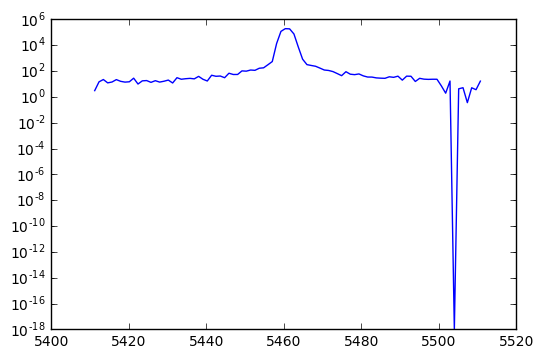

In [222]:
bfile = np.random.choice(blue_arc_files,1)[0]
arcline = my_blue_lines[7]
flux, wave, weights = window_arclines(bfile, 205, arcline, window_size = 50)
plt.semilogy(wave, flux)

In [195]:
def my_profile(x, g1_amp,g2_amp,l_amp, center,wave1, wave2, N_eff, g1_sig, g2_sig, c):
    gauss1 = g1_amp*np.exp(-(x-wave1)**2/(2*g1_sig**2.))
    gauss2 = g2_amp*np.exp(-(x-wave2)**2/(2*g2_sig**2.)) 
    core = gauss1 + gauss2 +c
    
    w = center/N_eff * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    scatt = l_amp*top/bot
    
    return np.convolve(core, scatt, 'same')

In [223]:
from lmfit import models, Parameters, Parameter, Model
mod = Model(my_profile)
params = mod.make_params()
params.add('g1_amp', value = 100, min = 0)
params.add('g2_amp', value = 100, min = 0)
params.add('l_amp', value = 100, min = 0)
params.add('center', value = arcline, vary = True)
params.add('wave2', value = arcline+0.6, min = arcline-3, max = arcline+3)
params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline+3)
params.add('N_eff', value = 60000, min = 0, max = N_eff_blue)
params.add('g1_sig', value = 1, min = 0)
params.add('g2_sig', value = 1, min = 0)
params.add('c', value = 9, min = 0)

model = mod.fit(flux, params, x=wave, weights=weights)

In [224]:
model.params.pretty_print()

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
N_eff   8.317e+04        0 8.32e+04 3.917e+06     True     None     None
c         0.5351        0      inf 4.281e+05     True     None     None
center      5461     -inf      inf   0.0967     True     None     None
g1_amp      5598        0      inf 4.478e+09     True     None     None
g1_sig     0.721        0      inf  0.02759     True     None     None
g2_amp      7634        0      inf 6.107e+09     True     None     None
g2_sig    0.8993        0      inf  0.02992     True     None     None
l_amp       1280        0      inf 1.024e+09     True     None     None
wave1       5460     5458     5464  0.08045     True     None     None
wave2       5461     5458     5464  0.08109     True     None     None


In [225]:
print(model.redchi)

5.24269592141


(1, 1000000)

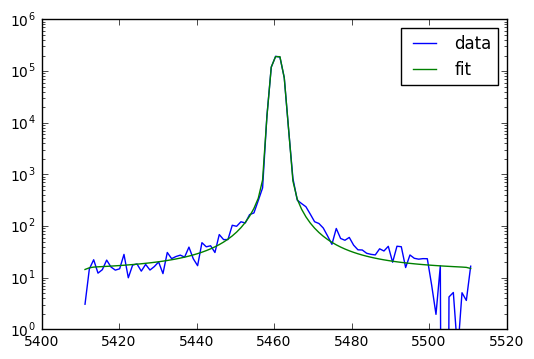

In [226]:
plt.semilogy(wave, flux, label = 'data')
plt.semilogy(wave, model.best_fit, label = 'fit')
plt.legend()
plt.ylim(pow(10,0), pow(10,6))

(5455, 5465)

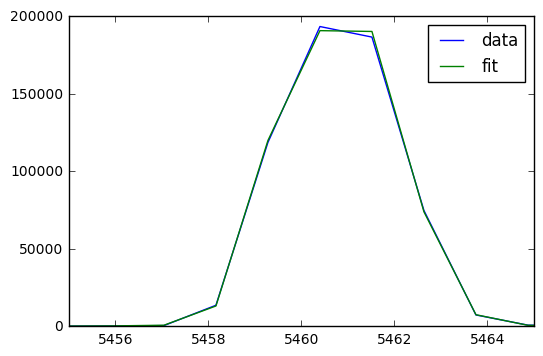

In [227]:
plt.plot(wave, flux, label = 'data')
plt.plot(wave, model.best_fit, label = 'fit')
plt.legend()
#plt.ylim(pow(10,0), pow(10,6))
plt.xlim(5455, 5465)

In [96]:
print(model.redchi)

19.9119661357


(5455, 5465)

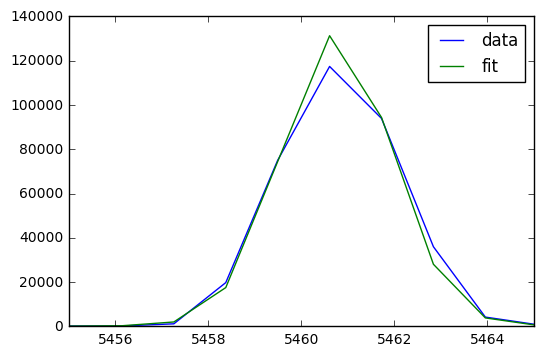

In [97]:
plt.plot(wave, flux, label = 'data')
plt.plot(wave, model.best_fit, label = 'fit')
plt.legend()
#plt.ylim(pow(10,0), pow(10,6))
plt.xlim(5455, 5465)

(1, 1000000)

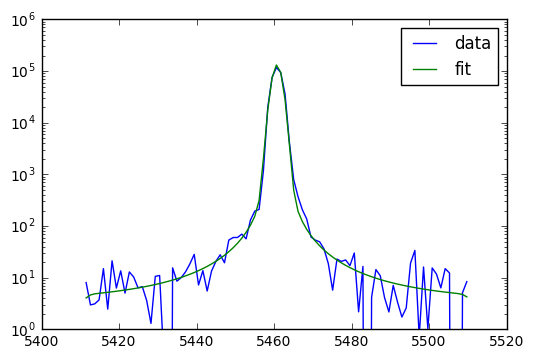

In [98]:
plt.semilogy(wave, flux, label = 'data')
plt.semilogy(wave, model.best_fit, label = 'fit')
plt.legend()
plt.ylim(pow(10,0), pow(10,6))

In [103]:
def get_mean_spectrum():
    wave_range = np.linspace(365,1040,(1040-365)*100)
    mean_file = np.random.choice(mean_files, 1)[0]
    mean_spectrum = np.load(mean_file)
    return wave_range, mean_spectrum

In [104]:
wave_range, spectrum = get_mean_spectrum()

In [117]:
Line = 557.89

In [135]:
def Yfit_test(N_eff, x,line,A,B):
    f = 0.5
    w = (1/(np.sqrt(2)*np.pi))*line/N_eff
    X = x - line
    top = w**2.
    bot = (X**2+w**2)
    return A*top/bot + B

(557, 559)

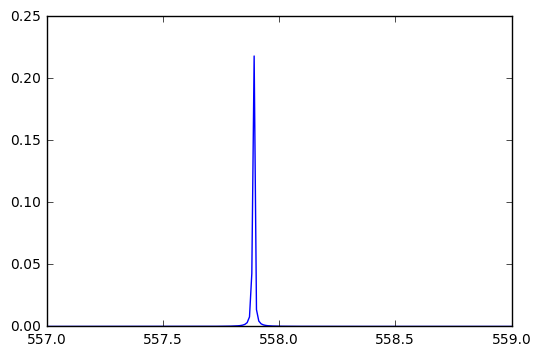

In [120]:
plt.plot(wave_range, Yfit_test(wave_range, Line))
plt.xlim(557,559)

In [126]:
p0 = Line, 10, 2
popt, pcov = curve_fit(Yfit_test, wave_range, spectrum['SKY'])
fit = Yfit_test(wave_range, *popt)
print(popt)

[ 1.          1.          3.33118374]


/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [138]:
N_eff_blue

83200

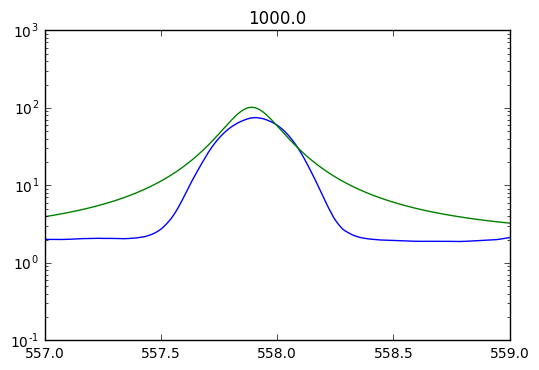

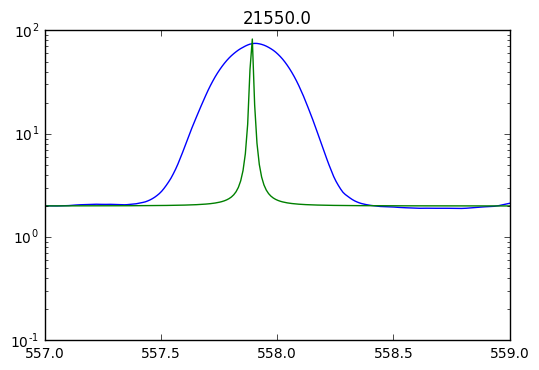

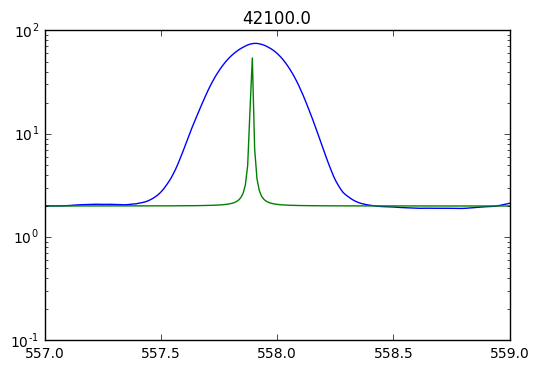

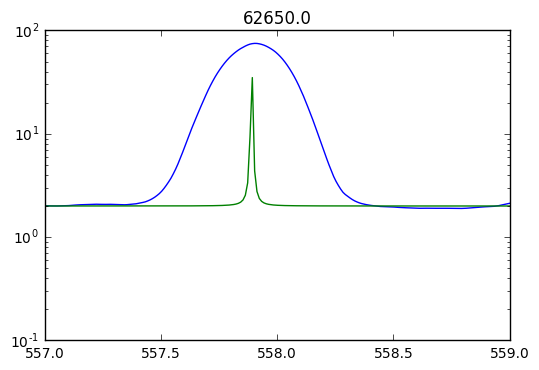

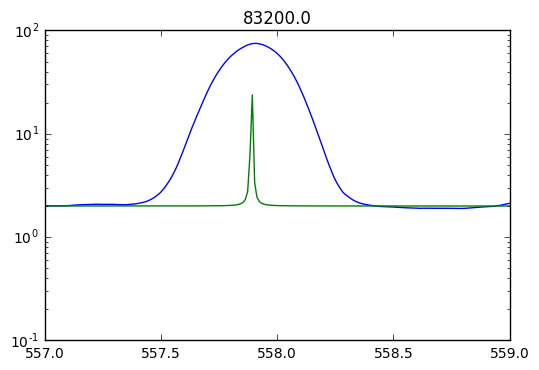

In [141]:
for N_eff in np.linspace(1000, N_eff_blue,5):
    plt.figure()
    plt.semilogy(wave_range, spectrum['SKY'],'b')
    plt.semilogy(wave_range, Yfit_test(N_eff, wave_range, Line, 100,2),'g')
    plt.title(N_eff)
    plt.xlim(557,559)

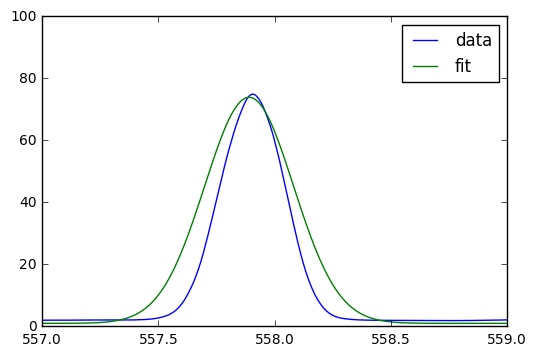

In [153]:
plt.plot(wave_range, spectrum['SKY'],label='data')
plt.plot(wave_range, gauss(wave_range, Line, 35, .45,1),label = 'fit')
plt.xlim(557,559)
plt.legend()

In [6]:
x = np.linspace(-80,80,161)

In [176]:
np.where((x<=-45)&(x<=45))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),)

In [25]:
blue_w = 496

In [26]:
wave_range = np.linspace(blue_w-50, blue_w+ 50,1000)

In [28]:
def gauss(wave_range, w_0, A, sigma, C):
    #sigma = fwhm/2.35
    return A*np.exp(-(wave_range-w_0)**2/(2*sigma**2.)) + C

In [33]:
def top_hat(x):
    f = np.zeros(len(x))
    idx = np.where((x>=blue_w-10)&(x<=blue_w+10))
    f[idx] = 1
    return f

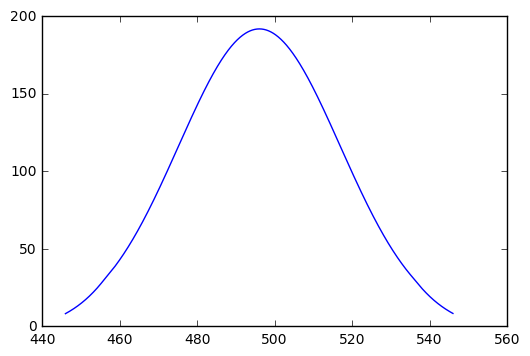

In [35]:
core = np.convolve(top_hat(wave_range), gauss(wave_range, blue_w, 1,20,0), 'same')
plt.plot(wave_range, core)

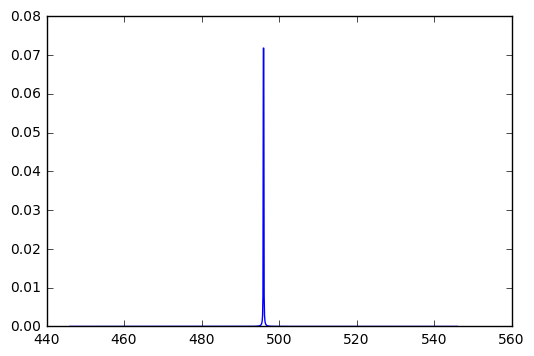

In [50]:
plt.plot(wave_range,scatter_profile(wave_range,100, blue_w, N_eff_blue))

In [56]:
profile = np.convolve(gauss(wave_range, blue_w, 1,20,0), scatter_profile(wave_range,100, blue_w, 10000),'same')

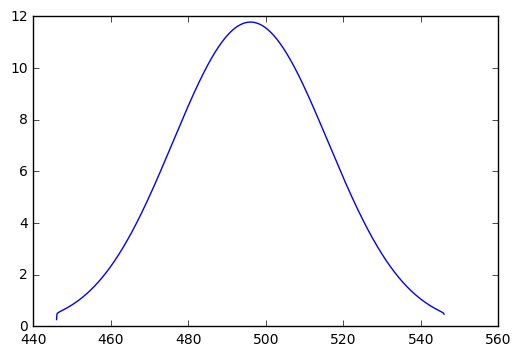

In [57]:
plt.plot(wave_range, profile)

In [185]:
s = 0.42*.0005*1.5
s

0.000315

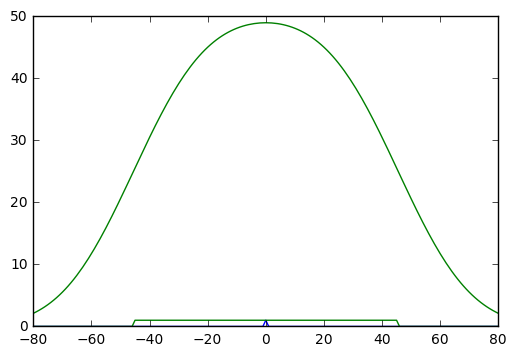

In [190]:
plt.plot(x, gauss(x,0,1,s,0))
plt.plot(x,top_hat(x))
plt.plot(x, np.convolve(top_hat(x),gauss(x,0,1,20,0),'same'),'g')

In [191]:
R_500 = 1500
fwhm = 500/1500
fwhm

0.3333333333333333